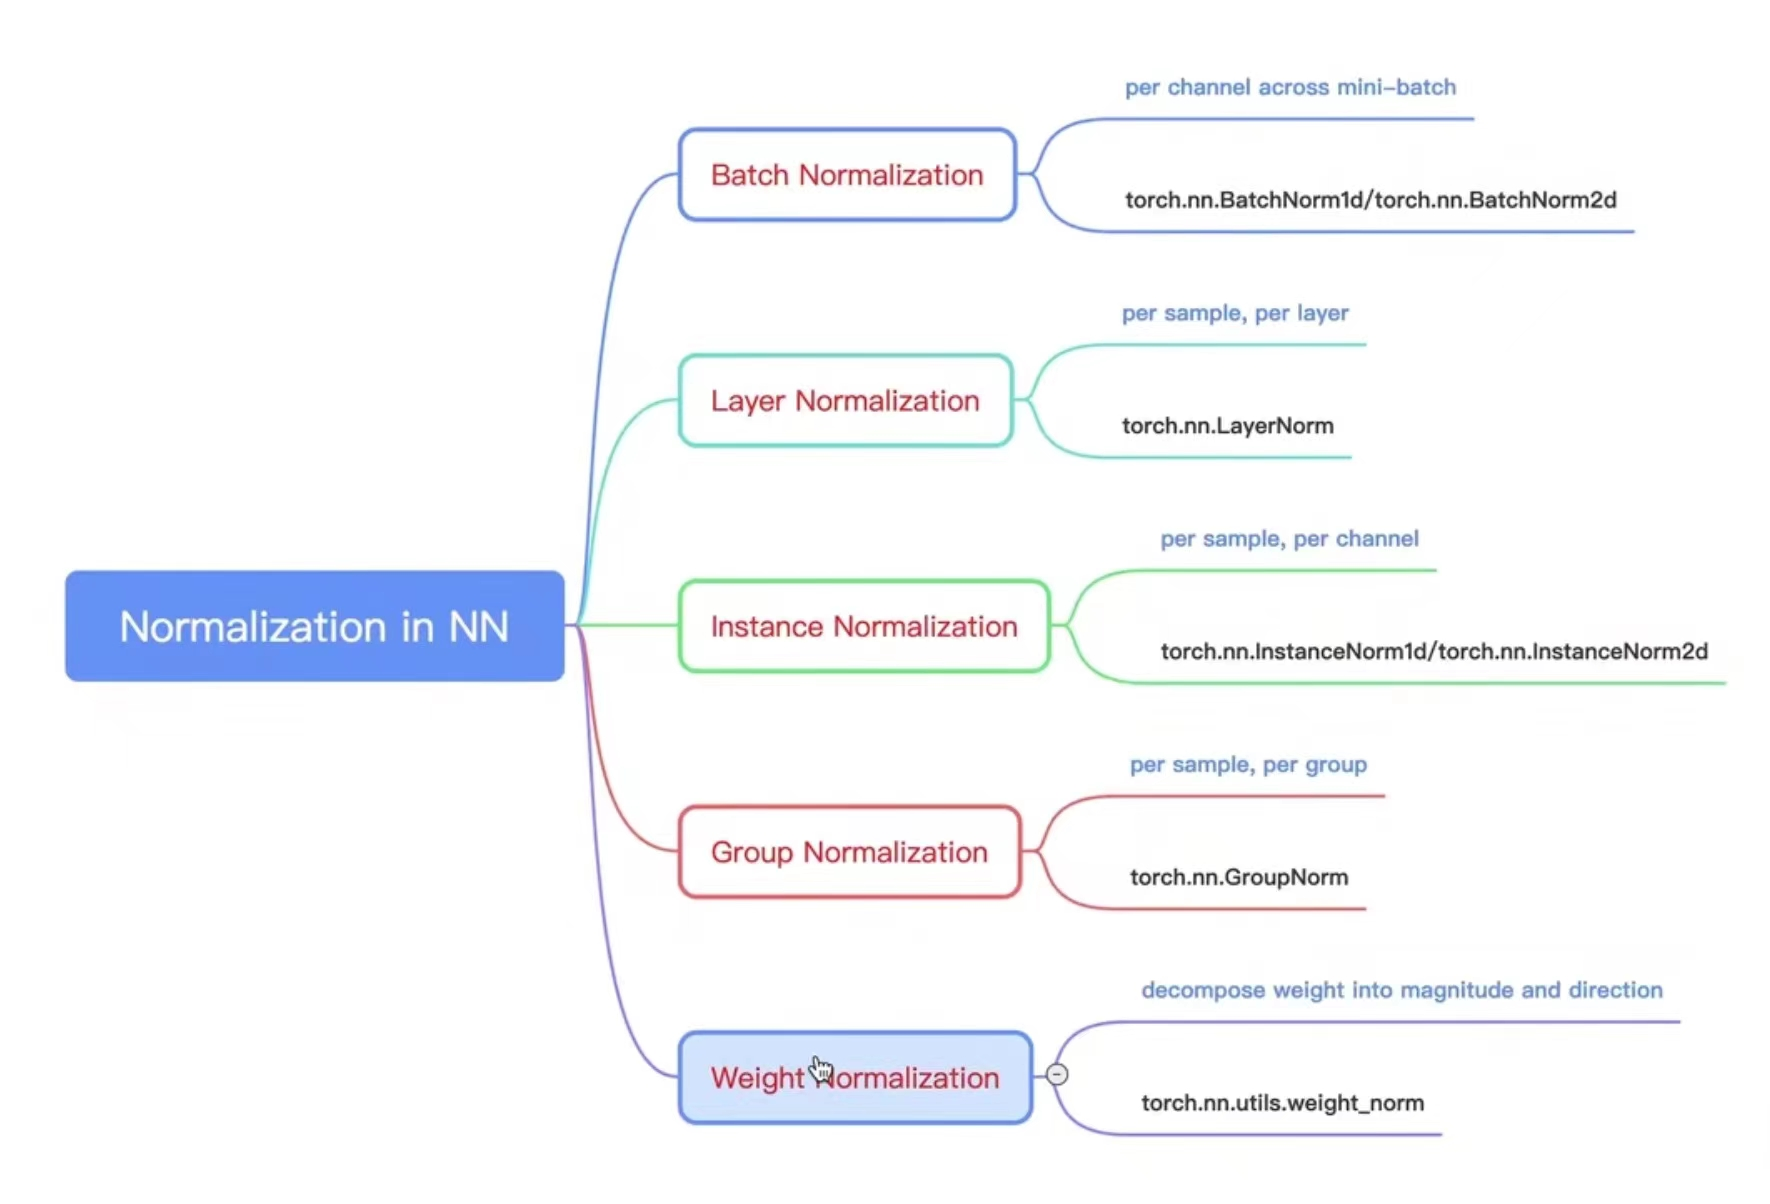

#### 标准化
  - per sample 针对单数据， batch_size 维度
  - per layer 在nlp中就是 seq_len 维度
  - per channel 在nlp中就是 embedding 维度
  - per group 一般是将 embedding 维度先分组，在标准化
  - 记住口诀， per 谁 谁维度不变 ，在其他维度求 均值和标准差

In [25]:
import torch 
from torch import nn

batch_size = 2
seq_len = 3
embedding_dim = 4
num_groups = 2


In [ ]:
inputx = torch.randn(batch_size, seq_len, embedding_dim)
inputx

tensor([[[ 2.2707,  2.2460, -0.1098,  0.8753],
         [ 0.2034, -0.2867,  0.1315, -0.8223],
         [ 0.3259,  2.2487,  0.8138,  0.1585]],

        [[ 0.2210,  1.3298, -1.8882, -1.5984],
         [-0.7538, -0.2709,  0.2285, -1.2446],
         [ 0.4646,  0.3041,  1.0410, -0.7868]]])

#### 1、Batch Norm
  - per channel cross mini-batch

In [ ]:
##### 1、调用 API 实现 BATCH Norm
# affine 是否设置 γ，伽马变换
# 输入要求是 [Batch_size, channel=embedding_dim, seq_len]
batch_norm_op = nn.BatchNorm1d(embedding_dim, affine=False)
bn_y = batch_norm_op(inputx.transpose(-1, -2)).transpose(-1, -2)
bn_y

tensor([[[ 2.0103,  1.2246, -0.1540,  1.7183],
         [-0.2789, -1.1295,  0.1006, -0.3003],
         [-0.1433,  1.2271,  0.8209,  0.8660]],

        [[-0.2595,  0.3730, -2.0313, -1.2233],
         [-1.3389, -1.1148,  0.2031, -0.8025],
         [ 0.0103, -0.5804,  1.0607, -0.2581]]])

In [13]:
## 手写实现
bn_mean = inputx.mean(dim=(0, 1), keepdim=True)
bn_std = inputx.std(dim=(0, 1), unbiased=False, keepdim=True)
verify_bn_y = (inputx - bn_mean) / bn_std
verify_bn_y, '----------', bn_y

(tensor([[[ 2.0103,  1.2246, -0.1540,  1.7183],
          [-0.2789, -1.1295,  0.1006, -0.3003],
          [-0.1433,  1.2271,  0.8209,  0.8660]],
 
         [[-0.2595,  0.3730, -2.0313, -1.2233],
          [-1.3389, -1.1148,  0.2031, -0.8025],
          [ 0.0103, -0.5804,  1.0607, -0.2581]]]),
 '----------',
 tensor([[[ 2.0103,  1.2246, -0.1540,  1.7183],
          [-0.2789, -1.1295,  0.1006, -0.3003],
          [-0.1433,  1.2271,  0.8209,  0.8660]],
 
         [[-0.2595,  0.3730, -2.0313, -1.2233],
          [-1.3389, -1.1148,  0.2031, -0.8025],
          [ 0.0103, -0.5804,  1.0607, -0.2581]]]))

#### 2、Layer Norm 
  - per sample 
  - per layer (seq_len维度)

In [15]:
## API 实现 Layer Norm 

layer_norm_op = nn.LayerNorm(embedding_dim, elementwise_affine=False)
ln_y = layer_norm_op(inputx)

In [16]:
## 手写实现 Layer Norm 
ln_mean = inputx.mean(dim=-1, keepdim=True)
ln_std = inputx.std(dim=-1, unbiased=False, keepdim=True)
verify_ln_y = (inputx - ln_mean) / ln_std

ln_y, '--------------', verify_ln_y

(tensor([[[ 0.9498,  0.9250, -1.4297, -0.4451],
          [ 0.9719, -0.2281,  0.7957, -1.5395],
          [-0.6820,  1.6562, -0.0887, -0.8855]],
 
         [[ 0.5329,  1.3710, -1.0615, -0.8424],
          [-0.4445,  0.4367,  1.3477, -1.3399],
          [ 0.3158,  0.0731,  1.1874, -1.5764]]]),
 '--------------',
 tensor([[[ 0.9498,  0.9250, -1.4297, -0.4451],
          [ 0.9719, -0.2281,  0.7957, -1.5396],
          [-0.6820,  1.6562, -0.0887, -0.8855]],
 
         [[ 0.5329,  1.3710, -1.0615, -0.8424],
          [-0.4445,  0.4367,  1.3477, -1.3399],
          [ 0.3158,  0.0731,  1.1874, -1.5764]]]))

#### 3、instance Norm
  - per sample 
  - per channel (embedding_dim)
  - 常用来实现风格消除，对seq_len 即所有时刻求均值，消除了所有时刻不变的东西，就是风格

In [17]:
## API 实现 INS Norm 
# 输入要求是 [bs, embedding_dim, seq_len]
ins_norm_op = nn.InstanceNorm1d(embedding_dim)
ins_y = ins_norm_op(inputx.transpose(-1, -2)).transpose(-1, -2)

In [24]:
## 手写ins norm 
ins_mean = inputx.mean(dim=1, keepdim=True)
ins_std = inputx.std(dim=1, unbiased=False, keepdim=True)
verify_ins_y = (inputx - ins_mean) / ins_std

ins_y, '---------------', verify_ins_y

(tensor([[[ 1.4122,  0.7059, -0.9927,  1.1566],
          [-0.7708, -1.4142, -0.3759, -1.2831],
          [-0.6414,  0.7083,  1.3686,  0.1265]],
 
         [[ 0.4630,  1.3223, -1.3622, -1.1692],
          [-1.3887, -1.0954,  0.3521, -0.1043],
          [ 0.9257, -0.2269,  1.0101,  1.2735]]]),
 '---------------',
 tensor([[[ 1.4122,  0.7059, -0.9927,  1.1566],
          [-0.7708, -1.4142, -0.3759, -1.2831],
          [-0.6415,  0.7083,  1.3686,  0.1265]],
 
         [[ 0.4630,  1.3223, -1.3622, -1.1692],
          [-1.3887, -1.0954,  0.3521, -0.1043],
          [ 0.9257, -0.2269,  1.0101,  1.2736]]]))

#### 4、Group Norm
  - per sample 
  - per group (embedding_dim 维度分组之后，每组单独进行 上述per sample 计算)

In [26]:
## API 实现
group_norm_op = nn.GroupNorm(num_groups, embedding_dim, affine=False)
gn_y = group_norm_op(inputx.transpose(-1, -2)).transpose(-1, -2)

In [31]:
## 手写实现
# 1、先按照embedding_dim维度分组，每一组包含 embedding_dim / num_group 个元素
group_inputxs = torch.split(inputx, split_size_or_sections=embedding_dim//num_groups, dim=-1)
# 2、分组，对每一组进行 per sample 标准化
results = []
for gn_inputx in group_inputxs:
    gn_mean = gn_inputx.mean(dim=(1, 2), keepdim=True)
    gn_std = gn_inputx.std(dim=(1, 2), unbiased=False, keepdim=True)
    gn_results = (gn_inputx - gn_mean) / gn_std
    results.append(gn_results)

verify_gn_y = torch.cat(results, dim=-1)
gn_y, '--------------', verify_gn_y

(tensor([[[ 0.9996,  0.9772, -0.4953,  1.2211],
          [-0.8744, -1.3187, -0.0750, -1.7368],
          [-0.7634,  0.9797,  1.1138, -0.0278]],
 
         [[ 0.0081,  1.7300, -1.1412, -0.8610],
          [-1.5058, -0.7558,  0.9057, -0.5188],
          [ 0.3864,  0.1371,  1.6914, -0.0761]]]),
 '--------------',
 tensor([[[ 0.9996,  0.9772, -0.4953,  1.2211],
          [-0.8744, -1.3187, -0.0750, -1.7368],
          [-0.7634,  0.9797,  1.1139, -0.0278]],
 
         [[ 0.0081,  1.7301, -1.1412, -0.8610],
          [-1.5058, -0.7558,  0.9057, -0.5188],
          [ 0.3864,  0.1371,  1.6914, -0.0761]]]))

#### 5、Weight Norm
  - 前面都是针对x的标准化，
  - 这个是针对 w 的标准化

In [ ]:
## API 实现
linear = nn.Linear(embedding_dim, 3, bias=False)
# wn_linear 包含 wn_linear.v 权重的方向 wn_linear.g 权重的幅度 （实际是一个可更新的参数，也就是对方向的加权）
wn_linear = torch.nn.utils.weight_norm(linear)
wn_linear_output = wn_linear(inputx)
print(wn_linear_output.shape)

torch.Size([2, 3, 3])


d:\application\Anaconda\envs\llama\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [33]:
## 手写实现
weight_direction = linear.weight / (linear.weight.norm(dim=1, keepdim=True))  # 权重的方向 w/ w的模长
weight_magnitude = wn_linear.weight_g # 获取，权重的幅度
print(weight_direction.shape)
print(weight_magnitude.shape)

torch.Size([3, 4])
torch.Size([3, 1])


In [35]:
verigy_wn_linear_output = inputx @ (weight_direction.transpose(-1, -2)) * weight_magnitude.transpose(-1, -2)

wn_linear_output, '-------------------', verigy_wn_linear_output

(tensor([[[ 0.3190,  1.1752, -1.1606],
          [ 0.2211,  0.1675, -0.0323],
          [-0.4583,  0.7319, -0.7375]],
 
         [[-0.6624,  0.8456, -0.2403],
          [-0.2282, -0.0285,  0.2100],
          [ 0.3067,  0.4123, -0.3547]]], grad_fn=<UnsafeViewBackward0>),
 '-------------------',
 tensor([[[ 0.3190,  1.1752, -1.1606],
          [ 0.2211,  0.1675, -0.0323],
          [-0.4583,  0.7319, -0.7375]],
 
         [[-0.6624,  0.8456, -0.2403],
          [-0.2282, -0.0285,  0.2100],
          [ 0.3067,  0.4123, -0.3547]]], grad_fn=<MulBackward0>))